# Detecting pneumonia using chest x-rays

### To Do List

#### Research:
* CNNs
    * How do they work?
    * Idea of transfer learning
* Unique CNN implementations: AlexNet, CapsNet, GNN
    * What is unique about each of these implementations?
    
#### Implementation:
* Basic CNNs (PyTorch, tensorflow, keras)
* Transfer learning example
* Unique CNN implementations
* Understanding what the CNN found important (https://github.com/albermax/innvestigate)

#### Blog:
* Choosing a service (Medium, ...)

## Research

#### Convolutional Neural Networks (CNNs)

CNNs are used for classifaction and computer vision. They are made up of three types of layers: convolutional, pooling, and fully-connected (FC). The first layer is a convolutional layer, and the last layer is the only fully-connected layer. The layers in between may be a mix of convolutional and pooling layers [1]. 

##### Convolutional Layers [1]
Convolutiuonal layers have an input, a filter (AKA kernel or feature detector), and a feature map. The feature detector is typically a 2D array of weights, which is applied to a subsection of the input. The dot product between this subsection and the kernel is then calculated. The filter then shifts by a stride, and performs the dot product operation once more, repeating this process until it has covered the entire input. The resulting array of outputs is called the feature map.

Some hyperparameters that can be adjusted in the convolutional layer are number of filters, stride, and zero padding. Number of filters affects the depth of the feature map (e.g. three filters results in a depth three feature map). Stride is the number of pixels the kernel moves after each dot product calculation. Zero padding refers to the amount of padding added to an input (eg. an image) to ensure that the filter fits the image.

After each convolution, the CNN applies a ReLU to introduce nonlinearities into the network, ensuring that the model is a universal approximator.

##### Pooling Layers [1]
Similar to a convolutional layer, except the filter does not use weights. Instead it implements a specific type of pooling: max pooling or average pooling. Max pooling is when the filter selects the pixel of maximum value to send to the output array. Average pooling is when the filter calculates the average value in the receptive field (the values that the filter can see).

More information is lost in pooling layers, but they "reduce complexity, improve efficiency, and limit risk of overfitting".

##### Fully-Connected Layer [1]
Usually uses a softmax activation function to make the final classification prediction.

## Implementation

In [45]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2 # https://pypi.org/project/opencv-python/
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
import os

#### Load Data [2]

In [2]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
                
            except Exception as e:
                print(e)
                
    return np.array(data)

In [3]:
train = get_training_data('./chest_xray/train')
test = get_training_data('./chest_xray/test')
val = get_training_data('./chest_xray/val')

OpenCV(4.5.1) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-oduouqig\opencv\modules\imgproc\src\resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.5.1) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-oduouqig\opencv\modules\imgproc\src\resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



C:\Users\willi_jnl\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


OpenCV(4.5.1) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-oduouqig\opencv\modules\imgproc\src\resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.5.1) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-oduouqig\opencv\modules\imgproc\src\resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



C:\Users\willi_jnl\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\willi_jnl\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


#### EDA (Exploratory Data Analysis) [2]

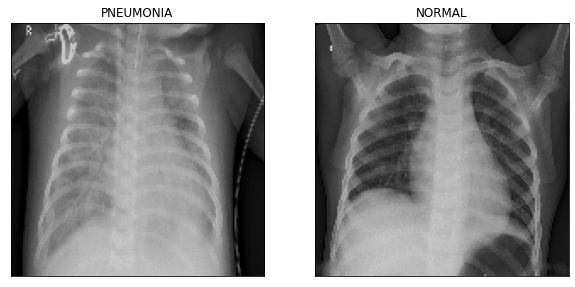

In [4]:
fig = plt.figure(figsize=(10,5))
a1 = fig.add_subplot(1,2,1)
plt.imshow(train[0][0], cmap='gray')
a1.set_title(labels[train[0][1]])
a1.set_xticks([])
a1.set_yticks([])

a2 = fig.add_subplot(1, 2, 2)
plt.imshow(train[-1][0], cmap='gray')
a2.set_title(labels[train[-1][1]])
a2.set_xticks([])
a2.set_yticks([])

plt.show()

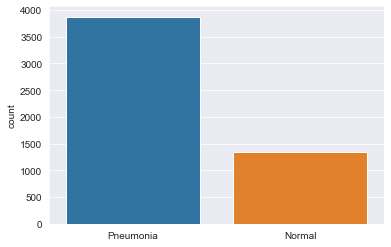

In [5]:
l = []
for i in train:
    if(i[1] == 0):
        l.append('Pneumonia')
    else:
        l.append('Normal')
        
sns.set_style('darkgrid')
sns.countplot(x=l)

plt.show()

#### Basic CNN Implementation [2]

In [6]:
# Preprocessing

x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)
    
for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [7]:
# Normalization

x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [40]:
# Resizing Data For CNN

x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [9]:
# Data Augmentation (Grayscales, Horizontal Flips, Vertical Flips, Random Crops, Color Jitters, Translations, Rotations, ...)
# Slightly alter the training data to increase the number of training examples and prevent overfitting

datagen = ImageDataGenerator(featurewise_center=False,
                             samplewise_center=False,
                             featurewise_std_normalization=False,
                             samplewise_std_normalization=False,
                             zca_whitening=False,
                             rotation_range=30,
                             zoom_range=0.2,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True,
                             vertical_flip=False)

datagen.fit(x_train)

In [34]:
# https://www.tensorflow.org/api_docs/python/tf/keras/

model = Sequential()
model.add(Conv2D(32, (3, 3), strides=1, padding='same', activation='relu', input_shape=(150, 150, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding='same'))
model.add(Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding='same'))
model.add(Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding='same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
dropout_7 (Dropout)          (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 38, 38, 64)       

In [36]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.3, min_lr=0.000001)

In [43]:
model.fit(datagen.flow(x_train, y_train, batch_size=32), epochs=12, 
          validation_data=datagen.flow(x_val, y_val), callbacks=[learning_rate_reduction])

model.save('./models/keras-cnn')

Epoch 1/12
163/163 [==============================] - 393s 2s/step - loss: 0.2487 - accuracy: 0.9066 - val_loss: 15.6693 - val_accuracy: 0.5000
Epoch 2/12
163/163 [==============================] - 372s 2s/step - loss: 0.2169 - accuracy: 0.9206 - val_loss: 1.1421 - val_accuracy: 0.5000
Epoch 3/12
163/163 [==============================] - 357s 2s/step - loss: 0.1875 - accuracy: 0.9317 - val_loss: 0.6453 - val_accuracy: 0.6875
Epoch 4/12
163/163 [==============================] - 372s 2s/step - loss: 0.1864 - accuracy: 0.9350 - val_loss: 0.6241 - val_accuracy: 0.5625
Epoch 5/12
163/163 [==============================] - 351s 2s/step - loss: 0.1752 - accuracy: 0.9431 - val_loss: 24.9159 - val_accuracy: 0.5000

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 6/12
163/163 [==============================] - 242s 1s/step - loss: 0.1221 - accuracy: 0.9574 - val_loss: 1.2133 - val_accuracy: 0.5000
Epoch 7/12
163/163 [==============================] - 230s 

In [46]:
model = load_model('./models/keras-cnn')

In [47]:
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 4s 169ms/step - loss: 0.2502 - accuracy: 0.9327
Accuracy of the model is -  93.2692289352417 %


## References

[1] https://www.ibm.com/cloud/learn/convolutional-neural-networks

[2] https://www.kaggle.com/madz2000/pneumonia-detection-using-cnn-92-6-accuracy

[3] https://data.mendeley.com/datasets/rscbjbr9sj/2 (THIS IS THE DATASET)